In [7]:
import pandas as pd
import numpy as np
from scipy.optimize import curve_fit
from scipy import stats

import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from matplotlib.pyplot import cm
from matplotlib import colors

First, let's input the data and setup our x (time) and y (species flow rates) arrays.

In [8]:
inputexcel = '190129 Space-time yields experimental data (5-133.1).xlsx' #ENTER EXCEL NAME HERE
inputsheet = 'Experimental Space-time yields' #ENTER SHEET NAME HERE

skipbeginpoints = 5; #MAX number of points to possibly skip at beginning
skipendpoints = 0; #number of points to skip at end 

ws = pd.read_excel(inputexcel, sheet_name=inputsheet)
headerstr = list(ws.head(0))
data = np.array(ws)
speciestr = list(data[0])
data = np.delete(data,0,0)
data = np.delete(data,0,0)

data = data.T #Now in format of data = [Ethane data[], Propene data[], ...]

timenp = data[0:2] #x np array
newtime = np.linspace(0,timenp[1,-1], num=len(timenp[1])) #for printing initial time points - used in graphing
speciesnp = data[2::] #y np array

#reformat column header list
speciestr = [x for x in speciestr if str(x) != 'nan']
speciestr.insert(0,str(headerstr[2])) #species headers 
timestr = headerstr[0:2] #time headers
stystr = headerstr[3] #STY header


We'll first try to fit using the hyperbolic, mulitsite deactivation curve. If this doesn't appear to be working (R^2 < 0.97), then we'll fit it to the exponential decay, single site deactivate curve.

In [9]:
def funcapp(x, y0, k, n): #apparent catalytic deactivation
    return (y0/((1+(n-1)*k*(y0**(n-1))*x)**(1/(n-1))))

def expdec(x, y0, k): #exponential decay
    return (y0*np.exp(-k*x))

In [10]:
#the maximum STY for each species
maxvales = np.amax(speciesnp, axis=1)

#initiate arrays and lists to populate
popt = np.empty((0,3), float) #fitted parameters
perr = np.empty((0,3), float) #standard deviate/error of parameters
chisq = [] #X^2 values
pval = [] #p values
rsq = [] #R^2 values
exceptions = [] #list of exceptions from hyperbolic, must use exp decay

for i, sp in enumerate(speciesnp): #loop through each species
    for j, point in enumerate(sp):
        if point < 0:
            sp[j] = 0
    if maxvales[i] < 1.0e-4: #if largest value is less than 1e-4, rescale with initial guess to be 1
        scale = maxvales[i]
        maxvales[i] = 1
    else:
        scale = 1

    r_squared = 0.0
    n = 0

#    while r_squared < 0.97 and n <= skipbeginpoints: #Try to fit the hyperbolic apparent function. Remove an additional initial point each run to gain a better fit.
#        timecrop = np.array(timenp)[::,n:] #crop time points to take into account skipped points
#        spcrop = np.array(speciesnp)[::,n:] #crop STY points to take into account skipped points
#
#        if skipendpoints != 0:
#            timecrop = np.array(timecrop)[::,:-skipendpoints]
#            spcrop = np.array(spcrop)[::,:-skipendpoints]/scale
#        else:
#            spcrop = spcrop/scale
#        
#        times = np.array(timecrop[1], dtype=float) #make curve_fit inputs explicit 1D np float arrays to reduce errors
#        rates = np.array(spcrop[i], dtype=float)
#        
#        try:
#            popti, pcovi = curve_fit(funcapp, times, rates, p0=(float(rates[0]), 0.0001, 2), bounds=((0,0, 1),(rates[0]*10+0.001,np.inf,5))) #once cropped, use first point as intial point
#            perri = np.sqrt(np.diag(pcovi))
#
#            residuals = spcrop[i]-funcapp(times, *popti) #residuals = ydata - f(xdata, popt)
#            ss_res = np.sum(residuals**2)                # SSres = SUMi (yi-fi)^2 = SUMi (residualsi)^2
#            ss_tot = np.sum((spcrop[i]-np.mean(spcrop[i]))**2) #SStot = SUMi (yi - ybar)^2
#            r_squared = 1 - (ss_res / ss_tot)            #R^2 = 1-SSres/SStot
#            n += 1
#        except RuntimeError: #If shape is bad, will not converge and throw an error. If this happens, we try to remove another point to reduce initial artifacts
#            n += 1
#    
#    n = 0
    if r_squared < 0.97: #If fit is still bad, we index to exceptions list for later
        exceptions.append(i)
        while r_squared < 0.97 and n <= skipbeginpoints: #Try to fit the exponential decay function. Remove an additional initial point each run to gain a better fit.
            timecrop = np.array(timenp)[::,n:] 
            spcrop = np.array(speciesnp)[::,n:] 

            if skipendpoints != 0:
                timecrop = np.array(timecrop)[::,:-skipendpoints]
                spcrop = np.array(spcrop)[::,:-skipendpoints]/scale
            else:
                spcrop = spcrop/scale
            
            times = np.array(timecrop[1], dtype=float) 
            rates = np.array(spcrop[i], dtype=float)

            popti, pcovi = curve_fit(expdec, times, rates, p0=(float(rates[0]), 0.0001), bounds=((0,0),(rates[0]*10+0.001,np.inf))) 
            perri = np.sqrt(np.diag(pcovi))

            residuals = spcrop[i]-expdec(times, *popti)
            ss_res = np.sum(residuals**2)
            ss_tot = np.sum((spcrop[i]-np.mean(spcrop[i]))**2)
            r_squared = 1 - (ss_res / ss_tot)
            n += 1
    
    if i in exceptions: #if exception, use exp decay
        popts = [popti[0]*scale,popti[1]] #rescale fitted parameters to original scale
        chisqa, pvala = stats.chisquare(expdec(times, *popts), spcrop[i], ddof=(spcrop.shape[1]-2)) #calculate X^2 and p value, ddof = # of points fitted - # of parameters fit (y0, k)
        perrs = [perri[0]*scale,perri[1],0.0] #to retain the same dimensions of popt for hyperbolic and exp decay, we add a 0 for a 1x3 popti and perri always
        popts.append(0.0)

#    else: #otherwise, use hyperbolic deactivation
#        popts = [popti[0]*scale,popti[1]*scale**(1-popti[2]),popti[2]] #rescale fitted parameters to original scale, 
#        perrs = [perri[0]*scale,perri[1]*scale**(1-popti[2]),perri[2]] ##rescale errors to original scale
#        chisqa, pvala = stats.chisquare(funcapp(times, *popts), spcrop[i], ddof=(spcrop.shape[1]-3)) #calculate X^2 and p value, # of points fitted - # of parameters fit (y0, kd, n)
        
    
    popt = np.vstack((popt, popts)) #add to our growing fitten parameter list
    perr = np.vstack((perr, perrs))
    rsq.append(r_squared)
    chisq.append(chisqa) #add to our growing X and p value list
    pval.append(pvala)

In [11]:
#Print fitted parameters ----

print('\033[1m'+'Apparent Model Fit'+'\033[0m')

rsqnp = np.array([rsq]) #turn list into array of (11,1) to play nice with the other arrays
chisqnp = np.array([chisq])
pvalnp = np.array([pval])

prspeciestr = speciestr.copy()
for i, sp in enumerate(prspeciestr): #mark our species exceptions with a *
    if i in exceptions:
        prspeciestr[i] = sp + "*"

#combine all output data - parameters
prpopt = np.append(popt, perr, 1)
prpopt = np.append(prpopt, rsqnp.T, 1)
prpopt = np.append(prpopt, chisqnp.T, 1)
prpopt = np.append(prpopt, pvalnp.T, 1)

prpopt = np.vstack((['y0', 'kd', 'n','y0 std dev', 'kd std dev', 'n std dev', 'r^2 value', 'X^2$ value','p value'], prpopt))

#create data frame (to export to excel)
prspeciestrparam = prspeciestr.copy()
prspeciestrparam.insert(0, 'Parameters')

dfpopt = pd.DataFrame(prpopt.T, columns = [prspeciestrparam])
display(dfpopt)


Apparent Model Fit


,Parameters,Conversion\n (R-based) %*,Ethane*,Propene*,isobutane*,n-butane*,C₄ alkanes*,trans-2-butene*,1-butene*,isobutene*,cis-2-butene*,C₄ alkenes*,C₅ alkanes*,C₅ alkenes*,C₆ alkanes*,C₆ alkenes*,C₇ alkanes*
0,y0,13.317980876635712,1.0518014332860754e-08,1.849802126495597e-09,6.105667333368967e-09,2.3249099752664865e-10,6.3502456165701535e-09,2.5079401634281536e-08,5.406655221405698e-09,6.630449524031542e-09,1.3977026125877326e-08,5.0064656664987675e-08,3.6310482272468865e-09,5.190595397014703e-09,2.073782964081582e-09,2.6014064826377086e-09,3.2434970389873244e-09
1,kd,5.480822435837929e-06,2.377202975406536e-05,1.7589432386217373e-05,0.00010650499336987347,2.5251946330004816e-05,9.864266644869051e-05,9.811499953153666e-06,9.487458506587965e-06,2.5075782268958445e-05,9.5356312124728e-06,1.0568929244655855e-05,9.673402336421083e-05,2.1029996669606852e-05,3.750103046469136e-05,9.141258853450279e-06,6.225380904932836e-05
2,n,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,y0 std dev,0.20338447295440065,3.836871440074233e-10,6.875208990848754e-11,1.415341974642209e-10,1.2324640478123147e-11,1.737240430792662e-10,3.9124523660395557e-10,8.029643632858026e-11,2.2419589399447441e-10,2.0999177506687555e-10,8.858399479294722e-10,8.492348993665689e-11,1.5248257966820228e-10,1.257023801353173e-10,4.825535939097672e-11,3.838470007276689e-10
4,kd std dev,2.6741595553749385e-07,1.1421583245997479e-06,9.86790045387201e-07,2.695377960081227e-06,1.7166527482353468e-06,2.9755420209655978e-06,3.197366229960945e-07,3.00862101445419e-07,1.090701415133684e-06,3.048883373780747e-07,3.7259593099125396e-07,2.5010383417846015e-06,8.591078166379373e-07,2.419235538813432e-06,3.7111826292476304e-07,5.85671796377453e-06
5,n std dev,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,r^2 value,0.9263657107496858,0.9573695121917565,0.930608367053375,0.990792906208661,0.9173006116487022,0.9861759259117753,0.9698124973617912,0.9711269199414705,0.9663669401833099,0.9706886925133207,0.965512634232997,0.9899486162568129,0.9668238021933826,0.9405994679440467,0.9543457208597068,0.898098439293033
7,X^2$ value,0.9429241796720202,9.293321528565608,8.939766955223881,5.2909739423450715,8.906123726312932,5.753231154676532,17.526743238034157,18.177331233962995,9.540165420622207,17.765279329977748,17.259734583532804,5.806850666306961,12.22618889704655,6.44656552161488,21.228073737293137,7.0629593072119645
8,p value,0.331526950382506,0.0022999076978803316,0.002790283173236153,0.02143622834081356,0.0028421592494032727,0.016458357922475166,2.8329474603486014e-05,2.0126017558016358e-05,0.0020102362491765694,2.4990237553619956e-05,3.2602289550068754e-05,0.015963858029194786,0.00047123356202039235,0.011116703734004854,4.077481644416577e-06,0.007869389937878302


In [12]:
#combine all output data - STY
prtime = np.insert(timenp,0,0,1)
data = np.vstack((prtime[0], prtime[1]))

for i, sp in enumerate(speciesnp):
    if i in exceptions:
        run = expdec(np.array(prtime[1], dtype = float),popt[i,0],popt[i,1])
    else:
        run = funcapp(np.array(prtime[1]), *popt[i])
    data = np.vstack((data, run)) 
    
prdata = timestr.copy() + prspeciestr
dfdata = pd.DataFrame(data.T, columns = prdata) #Modeled dataframe
display(dfdata)

prdata2 = timestr.copy() + speciestr
dataexp = np.vstack((timenp,speciesnp))
dfexpdata = pd.DataFrame(dataexp.T, columns = prdata2) #Experimental dataframe

,Time on stream [h],Time on stream [sec],Conversion (R-based) %*,Ethane*,Propene*,isobutane*,n-butane*,C₄ alkanes*,trans-2-butene*,1-butene*,isobutene*,cis-2-butene*,C₄ alkenes*,C₅ alkanes*,C₅ alkenes*,C₆ alkanes*,C₆ alkenes*,C₇ alkanes*
0,0,0,13.318,1.0518e-08,1.8498e-09,6.10567e-09,2.32491e-10,6.35025e-09,2.50794e-08,5.40666e-09,6.63045e-09,1.3977e-08,5.00647e-08,3.63105e-09,5.1906e-09,2.07378e-09,2.60141e-09,3.2435e-09
1,0.0619444,223,13.3017,1.04624e-08,1.84256e-09,5.96236e-09,2.31185e-10,6.21208e-09,2.50246e-08,5.39523e-09,6.59348e-09,1.39473e-08,4.99468e-08,3.55356e-09,5.16631e-09,2.05651e-09,2.59611e-09,3.19878e-09
2,0.535833,1929,13.1779,1.00466e-08,1.78809e-09,4.97174e-09,2.21438e-10,5.24991e-09,2.46092e-08,5.30861e-09,6.31736e-09,1.37223e-08,4.90543e-08,3.01296e-09,4.98424e-09,1.92906e-09,2.55594e-09,2.87647e-09
3,1.01222,3644,13.0546,9.64524e-09,1.73496e-09,4.14173e-09,2.12052e-10,4.43284e-09,2.41986e-08,5.22293e-09,6.05144e-09,1.34997e-08,4.81732e-08,2.55237e-09,4.80768e-09,1.8089e-09,2.51618e-09,2.58519e-09
4,1.48639,5351,12.9331,9.26168e-09,1.68364e-09,3.45323e-09,2.03106e-10,3.74588e-09,2.37967e-08,5.13902e-09,5.79788e-09,1.32817e-08,4.73119e-08,2.16387e-09,4.63816e-09,1.69674e-09,2.47722e-09,2.32456e-09
5,1.96028,7057,12.8127,8.89358e-09,1.63387e-09,2.87949e-09,1.94542e-10,3.16569e-09,2.34017e-08,5.05652e-09,5.55508e-09,1.30674e-08,4.64664e-08,1.83468e-09,4.4747e-09,1.59158e-09,2.43889e-09,2.09034e-09
6,3.49306,12575,12.431,7.80025e-09,1.48274e-09,1.59986e-09,1.69238e-10,1.83687e-09,2.21684e-08,4.79861e-09,4.83724e-09,1.23976e-08,4.38341e-08,1.07583e-09,3.98444e-09,1.29408e-09,2.31892e-09,1.48262e-09
7,3.9675,14283,12.3152,7.48989e-09,1.43886e-09,1.33377e-09,1.62094e-10,1.55206e-09,2.18e-08,4.72148e-09,4.63444e-09,1.21973e-08,4.30499e-08,9.11986e-10,3.84386e-09,1.21379e-09,2.28299e-09,1.33307e-09
8,4.44194,15991,12.2004,7.19187e-09,1.39627e-09,1.11193e-09,1.55252e-10,1.3114e-09,2.14377e-08,4.64558e-09,4.44014e-09,1.20003e-08,4.22797e-08,7.73096e-10,3.70824e-09,1.13848e-09,2.24763e-09,1.1986e-09
9,4.91389,17690,12.0873,6.90719e-09,1.35516e-09,9.27877e-10,1.48732e-10,1.10905e-09,2.10833e-08,4.5713e-09,4.25495e-09,1.18074e-08,4.15273e-08,6.55928e-10,3.57809e-09,1.06821e-09,2.21299e-09,1.0783e-09


In [13]:
#Export and plot in EXCEL ---
rgbacolors=cm.rainbow(np.linspace(0,1,speciesnp.shape[0]))
hexcolors = [] #split the rainbow into the number of species we have so we can make pretty plots
for c, color in enumerate(rgbacolors):
    run = colors.to_hex(color)
    hexcolors.append(run) #but excel only likes hex so fine let's convert everything

outputexcel = inputexcel.replace('.xlsx', ' - Modeled.xlsx') #name of new excel will just add "Modeled" to the old name
outputsheet = 'Yields Modeled' #name of new sheet

writer = pd.ExcelWriter(outputexcel, engine = 'xlsxwriter', options={'strings_to_numbers': True})

#write dataframes to excel document
dfdata.to_excel(writer, sheet_name = outputsheet, index=False, startrow = 1)
dfpopt.to_excel(writer, sheet_name = outputsheet, index=False, startcol=len(prdata)+1, startrow = 1)
dfexpdata.to_excel(writer, sheet_name = outputsheet, index=False, startrow = timenp.shape[1]+5)

workbook  = writer.book
worksheet = writer.sheets[outputsheet]

#excel formatting
worksheet.set_column('A:C', 13.5)
worksheet.set_column(len(prdata)+1, len(prdata)+2, 13.5)
format1 = workbook.add_format({'text_wrap': True, 'bold': True, 'align':'center'})
format2 = workbook.add_format({'text_wrap': True, 'bold': True, 'align':'center', 'bottom':True})

#format headers
for col, header in enumerate(prdata):
    worksheet.write(1, col , header , format1)
    
for col, header in enumerate(prdata):
    worksheet.write(timenp.shape[1]+5, col , header , format1)
    
for col, header in enumerate(prspeciestrparam):
    worksheet.write(1, col+len(prdata)+1, header , format1)
    
worksheet.write(1, len(prspeciestrparam)+len(prdata)+1, '' , format1)
worksheet.write(0, 0, 'Modeled Data' , format2)
worksheet.write(timenp.shape[1]+4, 0, 'Experimental Data' , format2)

#create chart
#categorties: x data | values: data
chart = workbook.add_chart({'type': 'scatter',
                             'subtype': 'smooth_with_markers'})

for i, species in enumerate(speciestr):
    if i == 0: #put conversion on the secondary axis, all other STY go to the primary axis
        y2 = 1
    else:
        y2 = 0
    chart.add_series({ #Modeled lines
        'name':       'Modeled {}'.format(species),
        'categories': [outputsheet, 2, 1, timenp.shape[1]+2, 1], #[sheetname, first_row, first_col, last_row, last_col]
        'values':     [outputsheet, 2, i+2, timenp.shape[1]+2, i+2],
        'marker':     {'type': 'none'},
        'line':       {'width': 1.5,
                       'color': '{}'.format(hexcolors[i])},
        'y2_axis': y2
        })
    
for i, species in enumerate(speciestr):
    if i == 0:
        y2 = 1
    else:
        y2 = 0
    chart.add_series({ #Experimental points
        'name':       '{}'.format(species),
        'categories': [outputsheet, timenp.shape[1]+6, 1, timenp.shape[1]*2+5, 1],
        'values':     [outputsheet, timenp.shape[1]+6, i+2, timenp.shape[1]*2+5, i+2],
        'marker':     {'type': 'circle', 
                        'size' : 4,
                         'border': {'color': 'black', 'width': 0.5},
                        'fill':   {'color': '{}'.format(hexcolors[i])}
                          },
        'line':   {'none':True},
        'y2_axis': y2
        })

chart.set_x_axis({'name': timestr[1],
                  'name_font': {'size': 10,
                                'bold': False},
                 'major_gridlines': {'visible': False},
                  'min': 0, 
                  'max': timenp[1,-1]
                 })
chart.set_y_axis({'name': stystr,
                  'name_font': {'size': 10,
                                'bold':False},
                 'major_gridlines': {'visible': False},
                 })
chart.set_y2_axis({'name': speciestr[0],
                  'name_font': {'size': 10,
                                'bold': False,
                               'color': '{}'.format(hexcolors[0])},
                 'major_gridlines': {'visible': False},
                 })

notlist = list(range(0, len(speciestr)-1))
notlist.append(len(speciestr)*2-2)
chart.set_legend({'font': {'size': 9}, 'delete_series': notlist})
chart.set_plotarea({'border': {'color': '#969696', 'width': 1, 'dash_type': 'solid'}})

worksheet.insert_chart(14, len(prdata)+1, chart, {'x_scale': 1.6, 'y_scale': 1.6})

worksheet.merge_range(0, 3, 0, int(len(speciestr)+1), stystr , format2)
worksheet.merge_range(timenp.shape[1]+4, 3, timenp.shape[1]+4, int(len(speciestr)+1), stystr , format2)

writer.save()
writer.close()

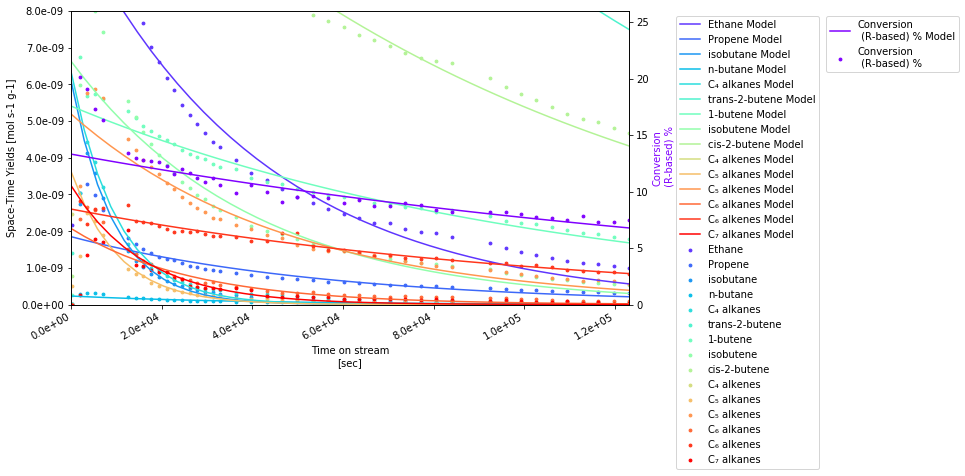

In [14]:
#Plot in python ---------
color=cm.rainbow(np.linspace(0,1,speciesnp.shape[0]))
fig, ax1 = plt.subplots(1, figsize=(10,6))
axes = plt.gca()   
axes.set_ylim(bottom=0.) #set rate axis > 0
ax1.set_xlabel(timestr[1])
ax1.set_xlim(0,timenp[1,-1])
ax1.xaxis.set_major_formatter(mtick.FormatStrFormatter('%.1e')) #show axis numbers in scientific notation
ax1.yaxis.set_major_formatter(mtick.FormatStrFormatter('%.1e'))
ax1.set_ylabel(stystr)
ax1.set_ylim(0,8e-9) #CHANGE THIS TO VIEW WHAT YOU WANT

ax2 = ax1.twinx() #plot conversion on a secondary axis
ax2.set_ylabel(speciestr[0], color = color[0])
ax2.set_ylim(0,26)

for i, sp in enumerate(speciesnp):
    if i == 0:
        ax2.scatter(timenp[1], speciesnp[i],  color=color[i], s=8, label=speciestr[i]) #plot exp data   
        if i in exceptions:
            ax2.plot(newtime,expdec(np.array(newtime), popt[i,0], popt[i,1]), color=color[i], label=speciestr[i]+' Model')
        else:
            ax2.plot(newtime,funcapp(np.array(newtime), *popt[i]), color=color[i], label=speciestr[i]+' Model') #plot fitted line 
    else:
        ax1.scatter(timenp[1], speciesnp[i],  color=color[i], s=8, label=speciestr[i]) #plot exp data  
        if i in exceptions:
            ax1.plot(newtime,expdec(np.array(newtime), popt[i,0], popt[i,1]), color=color[i], label=speciestr[i]+' Model') #plot fitted line
        else:
            ax1.plot(newtime,funcapp(np.array(newtime), *popt[i]), color=color[i], label=speciestr[i]+' Model')

ax1.legend(bbox_to_anchor=(1.35,1), loc='upper right', ncol=1)
ax2.legend(bbox_to_anchor=(1.6,1), loc='upper right', ncol=1)

fig.autofmt_xdate()
plt.show()